In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from matplotlib import pyplot as plt
import seaborn as sns 
from sklearn.metrics import r2_score
from cartopy import crs as ccrs, feature as cfeature

In [2]:
user = "Shop" #"Colin"
if (user == "Colin"):
  wd = 'C:/Users/cjcar/Dropbox/MalariaAttribution/Data'
  repo = "" #to fill in
elif (user == "Tamma"):
  wd ='/Users/tammacarleton/Dropbox/MalariaAttribution/Data'
  repo = '/Users/tammacarleton/Dropbox/Works_in_progress/git_repos/falciparum'
elif (user == "Shop"):
  wd = '/Users/bublai/Dropbox/ruins_remote_sensing/malaria'
  repo = '/Users/bublai/Desktop/research/falciparum/'
else:
  wd = NA
  print('Script not configured for this user!')

In [3]:
df = pd.read_csv("/Users/bublai/Dropbox/ruins_remote_sensing/malaria/formatted-backup.csv")

In [4]:
gdf = gpd.read_file('/Users/bublai/Dropbox/ruins_remote_sensing/malaria/AfricaADM1.shp')
gdf['OBJECTID'] = list(map(lambda x: int(x),gdf['OBJECTID']))
gdf = gdf.set_index('OBJECTID')

In [5]:
crs = ccrs.PlateCarree()

# This can be converted into a `proj4` string/dict compatible with GeoPandas
crs_proj4 = crs.proj4_init
gdf = gdf.to_crs(crs_proj4)
areas = gdf.geometry.area

In [6]:
areas

OBJECTID
65       0.455552
66       0.238144
67      38.941124
68       0.077574
69       0.142600
          ...    
3605     4.875515
3606     4.882640
3607     6.471893
3608     4.750354
3609     4.242086
Length: 853, dtype: float64

In [7]:
df.head()

,Unnamed: 0,OBJECTID,month,year,Pf,PfPR2,ppt,ppt2,R0,temp,temp2
0,1,65,Apr,1900,NaN,NaN,25.900001,672.500030,0.000000,15.60,243.360012
1,2,65,Apr,1901,NaN,NaN,37.550001,1411.105088,0.000001,15.75,248.065000
2,3,65,Apr,1902,NaN,NaN,21.550000,464.825009,0.000000,13.85,191.825011
3,4,65,Apr,1903,NaN,NaN,84.050003,7067.465513,0.000000,14.65,214.625003
4,5,65,Apr,1904,NaN,NaN,39.350000,1548.625029,0.000005,15.85,251.225012


In [8]:
l = []
for tup in df.itertuples():
    l.append(areas[tup[2]])
df['areas'] = l

In [9]:
df

,Unnamed: 0,OBJECTID,month,year,Pf,PfPR2,ppt,ppt2,R0,temp,temp2,areas
0,1,65,Apr,1900,NaN,NaN,25.900001,672.500030,0.000000,15.600000,243.360012,0.455552
1,2,65,Apr,1901,NaN,NaN,37.550001,1411.105088,0.000001,15.750000,248.065000,0.455552
2,3,65,Apr,1902,NaN,NaN,21.550000,464.825009,0.000000,13.850000,191.825011,0.455552
3,4,65,Apr,1903,NaN,NaN,84.050003,7067.465513,0.000000,14.650000,214.625003,0.455552
4,5,65,Apr,1904,NaN,NaN,39.350000,1548.625029,0.000005,15.850000,251.225012,0.455552
...,...,...,...,...,...,...,...,...,...,...,...,...
1207843,1207844,3609,Sep,2013,NaN,NaN,1.011111,1.965556,0.553776,22.133334,493.107796,4.242086
1207844,1207845,3609,Sep,2014,NaN,NaN,9.166667,119.998896,0.556516,22.194445,496.438348,4.242086
1207845,1207846,3609,Sep,2015,NaN,NaN,2.155556,10.960001,0.666648,22.961111,530.545012,4.242086
1207846,1207847,3609,Sep,2016,NaN,NaN,0.522222,0.327778,0.588302,22.383334,504.339463,4.242086


In [10]:
df_pre = df[df.year < 1980]

In [11]:
df_post = df[df.year >= 1980]

In [12]:
weighted_avg_gen = lambda data: lambda dfx: (dfx[data] * dfx["areas"]).sum() / dfx["areas"].sum()
avg_temp_pre = df_pre.groupby('year').apply(weighted_avg_gen('temp'))
avg_temp_post = df_post.groupby('year').apply(weighted_avg_gen('temp'))
avg_temp_total = df.groupby('year').apply(weighted_avg_gen('temp'))
avg_ppt_pre = df_pre.groupby('year').apply(weighted_avg_gen('ppt'))
avg_ppt_post = df_post.groupby('year').apply(weighted_avg_gen('ppt'))
avg_ppt_total = df.groupby('year').apply(weighted_avg_gen('ppt'))
avg_pre = df_pre.groupby('year').mean()
avg_post = df_post.groupby('year').mean()
avg_total = df.groupby('year').mean()

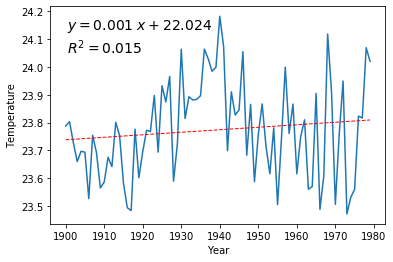

In [13]:
fig = plt.figure()
ax1 = fig.add_subplot()
ax1.set_ylabel('Temperature')
ax1.set_xlabel('Year')
x = avg_temp_pre.index.values
y = avg_temp_pre.values
plt.plot(x,y)
z = np.polyfit(x, y, 1)
y_hat = np.poly1d(z)(x)

plt.plot(x, y_hat, "r--", lw=1)
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
plt.gca().text(0.05, 0.95, text,transform=plt.gca().transAxes,
     fontsize=14, verticalalignment='top')
plt.savefig('/Users/bublai/Dropbox/ruins_remote_sensing/malaria/temp_pre.png')

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot()
ax1.set_ylabel('Temperature')
ax1.set_xlabel('Year')
x = avg_post.index.values
y = avg_post.values
plt.plot(x,y)
z = np.polyfit(x, y, 1)
y_hat = np.poly1d(z)(x)

plt.plot(x, y_hat, "r--", lw=1)
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
plt.gca().text(0.05, 0.95, text,transform=plt.gca().transAxes,
     fontsize=14, verticalalignment='top')
plt.savefig('/Users/bublai/Dropbox/ruins_remote_sensing/malaria/temp_post.png')

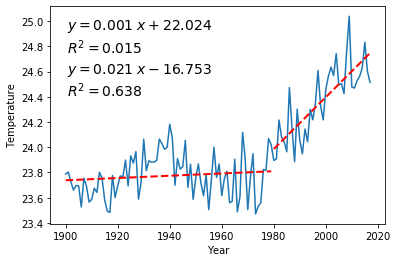

In [137]:
fig = plt.figure()
ax1 = fig.add_subplot()
ax1.set_ylabel('Temperature')
ax1.set_xlabel('Year')
x = avg_temp_total.index.values
y = avg_temp_total.values
plt.plot(x,y)
#plt.ylim(22,25)

z1 = np.polyfit(x[:80], y[:80], 1)
y_hat1 = np.poly1d(z1)(x[:80])

z2 = np.polyfit(x[80:], y[80:], 1)
y_hat2 = np.poly1d(z2)(x[80:])

plt.plot(x[:80], y_hat1, "r--", lw=2)
text1 = f"$y={z1[0]:0.3f}\;x{z1[1]:+0.3f}$\n$R^2 = {r2_score(y[:80],y_hat1):0.3f}$"
plt.gca().text(0.05, 0.95, text1,transform=plt.gca().transAxes,
     fontsize=14, verticalalignment='top')

plt.plot(x[80:], y_hat2, "r--", lw=2)
text2 = f"$y={z2[0]:0.3f}\;x{z2[1]:+0.3f}$\n$R^2 = {r2_score(y[80:],y_hat2):0.3f}$"
plt.gca().text(0.05, 0.75, text2,transform=plt.gca().transAxes,
     fontsize=14, verticalalignment='top')

plt.savefig('/Users/bublai/Dropbox/ruins_remote_sensing/malaria/temp_all.png')

In [138]:
##PRECIP BELOW 

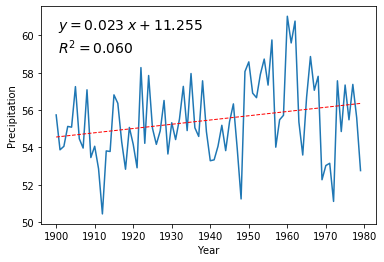

In [139]:
fig = plt.figure()
ax1 = fig.add_subplot()
ax1.set_ylabel('Precipitation')
ax1.set_xlabel('Year')
x = avg_ppt_pre.index.values
y = avg_ppt_pre.values
plt.plot(x,y)
z = np.polyfit(x, y, 1)
y_hat = np.poly1d(z)(x)

plt.plot(x, y_hat, "r--", lw=1)
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
plt.gca().text(0.05, 0.95, text,transform=plt.gca().transAxes,
     fontsize=14, verticalalignment='top')
plt.savefig('/Users/bublai/Dropbox/ruins_remote_sensing/malaria/ppt_pre.png')

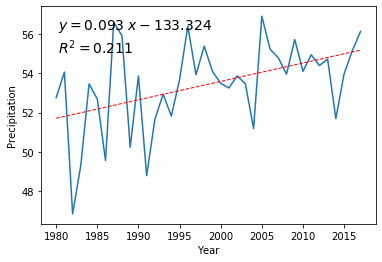

In [140]:
fig = plt.figure()
ax1 = fig.add_subplot()
ax1.set_ylabel('Precipitation')
ax1.set_xlabel('Year')
x = avg_ppt_post.index.values
y = avg_ppt_post.values
plt.plot(x,y)
z = np.polyfit(x, y, 1)
y_hat = np.poly1d(z)(x)

plt.plot(x, y_hat, "r--", lw=1)
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
plt.gca().text(0.05, 0.95, text,transform=plt.gca().transAxes,
     fontsize=14, verticalalignment='top')
plt.savefig('/Users/bublai/Dropbox/ruins_remote_sensing/malaria/ppt_post.png')

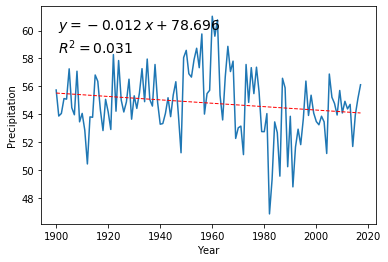

In [141]:
fig = plt.figure()
ax1 = fig.add_subplot()
ax1.set_ylabel('Precipitation')
ax1.set_xlabel('Year')
x = avg_ppt_total.index.values
y = avg_ppt_total.values
plt.plot(x,y)
z = np.polyfit(x, y, 1)
y_hat = np.poly1d(z)(x)

plt.plot(x, y_hat, "r--", lw=1)
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
plt.gca().text(0.05, 0.95, text,transform=plt.gca().transAxes,
     fontsize=14, verticalalignment='top')
plt.savefig('/Users/bublai/Dropbox/ruins_remote_sensing/malaria/ppt_all.png')

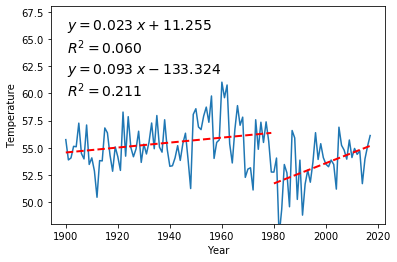

In [18]:
fig = plt.figure()
ax1 = fig.add_subplot()
ax1.set_ylabel('Temperature')
ax1.set_xlabel('Year')
x = avg_ppt_total.index.values
y = avg_ppt_total.values
plt.plot(x,y)
plt.ylim(48,68)

z1 = np.polyfit(x[:80], y[:80], 1)
y_hat1 = np.poly1d(z1)(x[:80])

z2 = np.polyfit(x[80:], y[80:], 1)
y_hat2 = np.poly1d(z2)(x[80:])

plt.plot(x[:80], y_hat1, "r--", lw=2)
text1 = f"$y={z1[0]:0.3f}\;x{z1[1]:+0.3f}$\n$R^2 = {r2_score(y[:80],y_hat1):0.3f}$"
plt.gca().text(0.05, 0.95, text1,transform=plt.gca().transAxes,
     fontsize=14, verticalalignment='top')

plt.plot(x[80:], y_hat2, "r--", lw=2)
text2 = f"$y={z2[0]:0.3f}\;x{z2[1]:+0.3f}$\n$R^2 = {r2_score(y[80:],y_hat2):0.3f}$"
plt.gca().text(0.05, 0.75, text2,transform=plt.gca().transAxes,
     fontsize=14, verticalalignment='top')

plt.savefig('/Users/bublai/Dropbox/ruins_remote_sensing/malaria/ppt_all.png')